In [1]:
import pandas as pd
from JigsawDataLoader import *
from JigsawNetwork import Network

from fastprogress.fastprogress import master_bar, progress_bar

import torch
import torch.nn as nn
import torch.nn.functional as F

gpu_id = 0
num_cores = 4
torch.cuda.set_device(gpu_id)

In [2]:
def subsample_dl(ds, bs=16, pct=0.1, seed=None):
    """Takes a DataLoader object as input and returns a mini-version of the dataset
    This is useful for debugging and rapid experimentation. 
    data -> a databunch object
    pct  -> the fraction of original dataset size (default: 0.1)"""
    import numpy as np
    if seed: np.random.seed(seed)
    size = len(ds)
    indices = np.random.choice(np.arange(size), 
                                   size=int(pct*size), replace=False)
    sampler = torch.utils.data.sampler.SubsetRandomSampler(indices)
    mini_dl = torch.utils.data.DataLoader(dataset=ds,
                                            batch_size=bs,
                                            sampler=sampler,
                                            num_workers=4)
    return mini_dl

#### train args

In [3]:
import sys
sys.path.append('../')
from utils import find_lr

In [4]:
bs = 16

In [5]:
train_pth = pd.read_csv('../train.csv')
train_ds = DataLoader(train_pth)
train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                            batch_size=bs,
                                            shuffle=True,
                                            num_workers=num_cores)
sub_train_loader = subsample_dl(train_ds, bs)

In [6]:
len(train_ds), len(train_loader), len(sub_train_loader)

(79997, 5000, 500)

In [7]:
val_pth = pd.read_csv('../valid.csv')
val_ds = DataLoader(val_pth)
val_loader = torch.utils.data.DataLoader(dataset=val_ds,
                                            batch_size=bs,
                                            shuffle=True,
                                            num_workers=num_cores)
sub_val_loader = subsample_dl(val_ds, bs)

In [8]:
len(val_ds), len(val_loader), len(sub_val_loader)

(20000, 1250, 125)

In [9]:
train_data = sub_train_loader
val_data = sub_val_loader

#### TODO: add validation data

In [10]:
iter_per_epoch = len(train_data)
# print('Images: train %d, validation %d'%(train_data.N,val_data.N))

In [11]:
net = Network()
net = net.cuda()

In [12]:
# loss func and optimizer
lr = 0.01
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=0.9,weight_decay = 5e-4)

## find_lr

In [13]:
import matplotlib.pyplot as plt

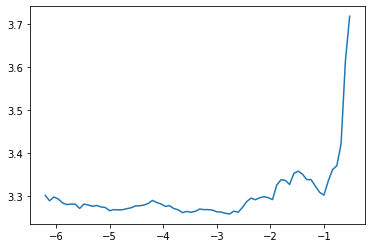

In [14]:
logs,losses = find_lr(net, train_data, optimizer, criterion, 1e-07, 10)
plt.plot(logs[10:],losses[10:])

# one_cycle

In [25]:
len(train_data)

500

In [26]:
len(lrs)

500

In [15]:
def get_lrs(dataloader, max_lr=1e-3, min_lr=None, max_mom=0.95):
    """This function returns arrays for learning rates and momentum
    following the One Cycle Policy"""
    num_batches = len(dataloader)
    if not min_lr: min_lr = max_lr/10
    lrs_up = np.linspace(min_lr, max_lr, num_batches // 2)
    lrs_down = np.linspace(max_lr, min_lr, (num_batches // 2)+1)
    moms_up = np.linspace(max_mom-0.1, max_mom, num_batches // 2)
    moms_down = np.linspace(max_mom, max_mom-0.1, (num_batches // 2)+1)
    if not num_batches%2:
        print(num_batches)
        lrs_down = lrs_down[1:]
        moms_down = moms_down[:-1]
    total_lrs = np.concatenate([lrs_up, lrs_down])
    total_moms = np.concatenate([moms_down, moms_up])
    return total_lrs, total_moms

In [18]:
import numpy as np

500


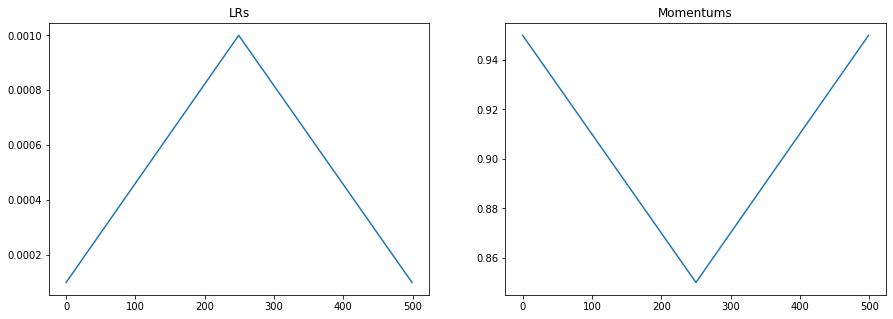

In [19]:
lrs, moms = get_lrs(train_data)
# lrs[0], moms[0]
figsize = (15, 5)
f, axarr = plt.subplots(1, 2, figsize=figsize)  # create visualizations
axarr[0].plot(lrs)
axarr[0].set_title("LRs")
axarr[1].plot(moms)
axarr[1].set_title("Momentums")
plt.show()

In [21]:
loss_function = F.mse_loss
optimizer = torch.optim.SGD(net.parameters(), lr=lrs[0], momentum=moms[0])

In [27]:
batch_time, net_time = [], []
for epoch in range(50):
#         if epoch%10==0 and epoch>0:
#             test(net,criterion,logger_test,val_loader,steps)
#         lr = adjust_learning_rate(optimizer, epoch, init_lr=args.lr, step=20, decay=0.1)
        net.train()
        total_loss = 0
        total_items = 0
        for i, (images, labels) in enumerate(progress_bar(train_data)):
            optimizer.param_groups[0]['lr'] = lrs[i]
            optimizer.param_groups[0]['momentum'] = moms[i]
            
            images = images.cuda()
            labels = labels.cuda()          
            outputs = net(images)
            
            loss = F.cross_entropy(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()*len(labels)
            total_items += len(labels)
            
            
        train_loss = total_loss / total_items
        print(f'Train loss {train_loss:.2f}')

Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


Train loss 3.18


In [ ]:
def valid_metrics(model, valid_dl):
    model.eval()
    total_loss = 0
    total_true = 0
    total_items = 0
    for images, y in valid_dl:
        images = Variable(images)
        images = images.cuda()
        out = model(images)
        out = out.cpu().data
        loss = F.cross_entropy(out, y)
        total_loss += loss.item()*len(y)
        total_true += (out.argmax(dim=1) == y).sum().item()
        total_items += len(y)
    val_loss = total_loss / total_items
    val_acc = total_true / total_items
    print(f'Valid loss {val_loss:.2f}')
    print(f'Accuracy: {val_acc:.2f}')
    return val_loss, val_acc

In [ ]:
valid_metrics(net, val_data)